In [60]:
# Data Loading
import requests
from ast import literal_eval
from copy import deepcopy

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import numpy as np
import pandas as pd

# Machine Learning
import torch
from torch.optim.sgd import SGD
from torch.nn import Module, LSTM, Linear, Softmax, CrossEntropyLoss
from torch.utils.data import random_split

We begin by loading card data from [Scryfall](https://scryfall.com/), a Magic: The Gathering search engine and data aggregator. We clean the data by removing weirdly formatted cards, as well as cards that contain rarely used characters.

In [2]:
cards_raw = pd.read_json('data/scryfall-data.zip')

# Remove all multi-faced or other weirdly formatted cards
cards_raw = cards_raw[cards_raw['layout'] == 'normal']

# Remove all digital-only cards
cards_raw = cards_raw[~cards_raw['digital']]

# Remove all joke cards
cards_raw = cards_raw[cards_raw['set_type'] != 'funny']

# Remove cards with no text
cards_raw = cards_raw[cards_raw['oracle_text'].str.len() > 0]

### The next few steps reduce the number of characters we will have to one-hot encode ###
# Remove cards that have uncommon characters
cards_raw = cards_raw[~cards_raw['oracle_text'].str.contains(r'[!%?úíÉ\[\]]')]

# Fix index
cards_raw = cards_raw.reset_index(drop=True)

# Replace "minus" with "hyphen", as they fulfil the same purpose
cards_raw['oracle_text'] = cards_raw['oracle_text'].str.replace('−', '-')

# Replace semicolon with comma, as they are close enough
cards_raw['oracle_text'] = cards_raw['oracle_text'].str.replace(';', ',')

### Generalize card names appearing in rules text ###
# This is because the name of the card is irrelevant to its effect, 
# and cards can even be reprinted with different names
def generalize_name(card):
    generalized = card.copy()
    generalized['oracle_text'] = card['oracle_text'].replace(card['name'], '~')
    return generalized

cards = cards_raw.apply(generalize_name, axis=1)

We then load data from EDHREC, another data aggregator, which has tags on many cards relating to their purpose (e.g. removing threats, playing more mana, etc.).

In [3]:
# Try to load EDHREC data; if it doesn't exist, regenerate it
try:
    edhrec_tags = pd.read_csv('data/edhrec_data.csv', index_col=0).applymap(literal_eval, na_action='ignore')
except:
    # Replace all special characters with hyphens, other than apostrophes, to match EDHREC format
    edhrec_names = cards['name'].str.lower().str.replace('\'', '').str.replace(r'\W+', '-', regex=True)

    # Split the names into 300 card chunks to fit EDHREC API requirements, then query the API
    edhrec_name_chunks = np.array_split(edhrec_names.to_numpy(), range(300, edhrec_names.shape[0], 300))
    edhrec_results = [ requests.post('https://edhrec.com/api/cards/', json={'format': 'dict', 'names': list(chunk)}).json()['cards'] for chunk in edhrec_name_chunks ]

    # Get the tags for the cards
    edhrec_tags = pd.concat([pd.DataFrame(res).T for res in edhrec_results ])['tags']
    # Reindex tags based on card name
    edhrec_tags = pd.merge(edhrec_names, edhrec_tags, left_on='name', right_index=True)['tags']

    # Save to CSV
    edhrec_tags.to_csv('data/edhrec_data.csv')

# Add the tags to our card data
cards_tagged = cards.join(edhrec_tags)
# Drop cards with no tags
cards_tagged = cards_tagged[~cards_tagged['tags'].isnull()].reset_index(drop=True)

C:\Users\kfish\AppData\Local\Temp\ipykernel_14580\3858669450.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edhrec_tags = pd.read_csv('data/edhrec_data.csv', index_col=0).applymap(literal_eval, na_action='ignore')


Finally, we load the "Oracle text" of the cards (the text of the cards under the rules, including errata and updates for uniformity). We convert it into one-hot encoding by characters, then into a packed sequence of tensors for batching.

In [4]:
# The size of each character tensor
INPUT_SIZE = 80

# Get the frequency of each character in the corpus
char_freqs = pd.Series(list(''.join(cards_tagged['oracle_text']))).value_counts()
# Ensure we only have 80 characters appearing
assert(char_freqs.shape[0] == INPUT_SIZE)

# Mapping from a character into its index
char_indices = pd.Series(range(INPUT_SIZE), index=char_freqs.index)

# Turn the text of all cards into a packed (jagged) tensor
tensor_text = [ torch.tensor(np.identity(INPUT_SIZE)[char_indices[list(text)]]).float() for text in cards_tagged['oracle_text'] ]

Similarly, we load the tags into a tensor to be our labels/training data.

In [5]:
OUTPUT_SIZE = 7

# Get the frequencies of each category
tag_freqs = cards_tagged['tags'].explode().value_counts()
# Ensure we only have 7 categories
assert(tag_freqs.shape[0] == OUTPUT_SIZE)

# Mapping from a tag into its index
tag_indices = pd.Series(range(OUTPUT_SIZE), index=tag_freqs.index)

# One-hot encoding, but with the possibility of multiple categories
tensor_tags = [ torch.tensor(np.identity(OUTPUT_SIZE)[tag_indices[tags]].mean(axis=0)).float() for tags in cards_tagged['tags'] ]

We now create the model, consisting of an LSTM layer, followed by a linear layer and a sigmoid activation.

In [27]:
class MTGClassifier(Module):
    def __init__(self, input_size, hidden_size, output_size, layers):
        super(MTGClassifier, self).__init__()
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size

        self.lstm = LSTM(input_size, hidden_size, layers)
        self.linear = Linear(hidden_size, output_size)
        self.activation = Softmax(dim=1)

    def forward(self, input):
        out, _ = self.lstm(input)
        out = self.linear(out)
        out = self.activation(out)
        return out

In [ ]:
HIDDEN_SIZE = 60

torch.manual_seed(42)

model = MTGClassifier(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, 2)

# Inversely weight the categories, so that we don't get too much focus on the largest one
inverse_freqs = 1/tag_freqs
weights = inverse_freqs/inverse_freqs.sum()
loss_func = CrossEntropyLoss(weight=torch.tensor(weights.to_numpy()))

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Split data into 80/20 train/test
text_tagged = list(zip(tensor_text, tensor_tags))
train_data, test_data = random_split(text_tagged, [ 0.8, 0.2 ])

N_EPOCHS = 1000
losses = np.zeros((N_EPOCHS, len(train_data)))
test_losses = np.zeros(N_EPOCHS)

with torch.no_grad():
    best_model = (deepcopy(model), torch.stack([ loss_func(model(test)[-1], tags) for test, tags in test_data ]).mean())

for epoch in range(N_EPOCHS):
    print("Epoch:", epoch)
    # Clear accumulated gradient
    model.zero_grad()
    for i, (text, tags) in enumerate(train_data):
        # Calculate probabilities from sequence
        probabilities = model(text)

        loss = loss_func(probabilities[-1], tags)
        losses[epoch, i] = loss
        loss.backward()
    optimizer.step()

    print("\tError:", losses[epoch].mean())

    with torch.no_grad():
        test_losses[epoch] = torch.stack([ loss_func(model(test)[-1], tags) for test, tags in test_data ]).mean()

    if best_model[1] > test_losses[epoch]:
        best_model = (deepcopy(model), test_losses[epoch])

    print("\tTest Error:", test_losses[epoch])

<Axes: >

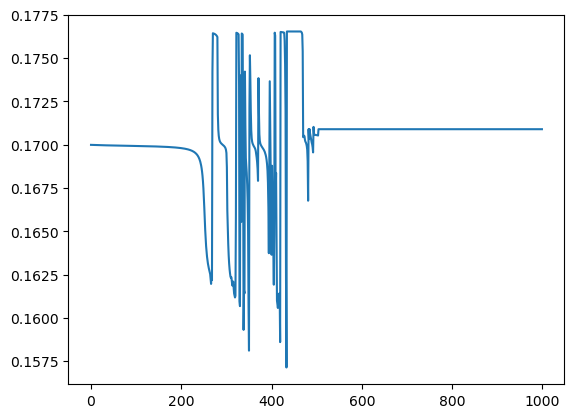

In [85]:
sns.lineplot(x=range(N_EPOCHS), y=losses.mean(axis=1))